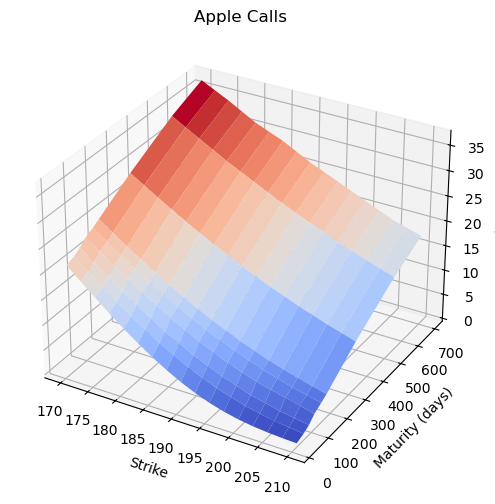

In [1]:
import warnings
warnings.filterwarnings("ignore")

import readPlotOptionSurface
import modulesForCalibration as mcf

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
#Parametri (estratti da bloomberg)
alpha = 1.5
eta = 0.2

n = 12

#Scelta del Modello
model = "Heston"

#AAPL (estratto da bloomberg per quello specifico giorno)
r = 0.0245
q = 0.005
S0 = 190.3

In [3]:
#Finding a starting point
#Heston params = (kappa, teta, lambda, rho, vu0)
params1 = (1.0, 0.02, 0.05, -0.4, 0.08)
params2 = (3.0, 0.06, 0.10, -0.6, 0.04)


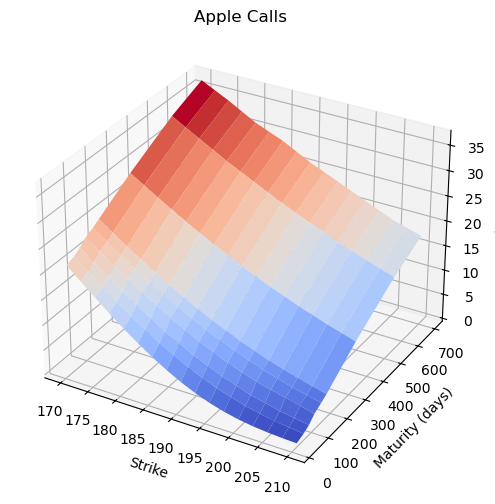

In [4]:
iArray = []
rmseArray = []
rmseMin = 1e10

maturities, strikes, callPrices = readPlotOptionSurface.readNPlot()

marketPrices = callPrices
maturities_years = maturities/365

In [5]:
#Creo l'interpolazione per diverse i (alfa) ottengo diverse combinazioni di parmas1 e parmas2

for i in mcf.myRange(0, 1, 0.05):
    params = i*np.array(params1) + (1.0-i)*np.array(params2)

    #Per ogni combinazione ottengo un dato parmas(i) che userò per calcolare il prezzo delle call
    iArray.append(i)

    try:
        #Ad ogni prezzoCall(i) calcolo il RMSE(i) 
        rmse = mcf.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model) 

        rmseArray.append(rmse)
        if (rmse < rmseMin):
            rmseMin = rmse
            optimParams = params

    except Exception as e:
        print(f"errore durante il calcolo per i={i}: {e}")
        iArray.pop()


#Stampo lo starting point
print(rmseMin)
print(optimParams)


0.8658939945597864
[ 2.3     0.046   0.0825 -0.53    0.054 ]


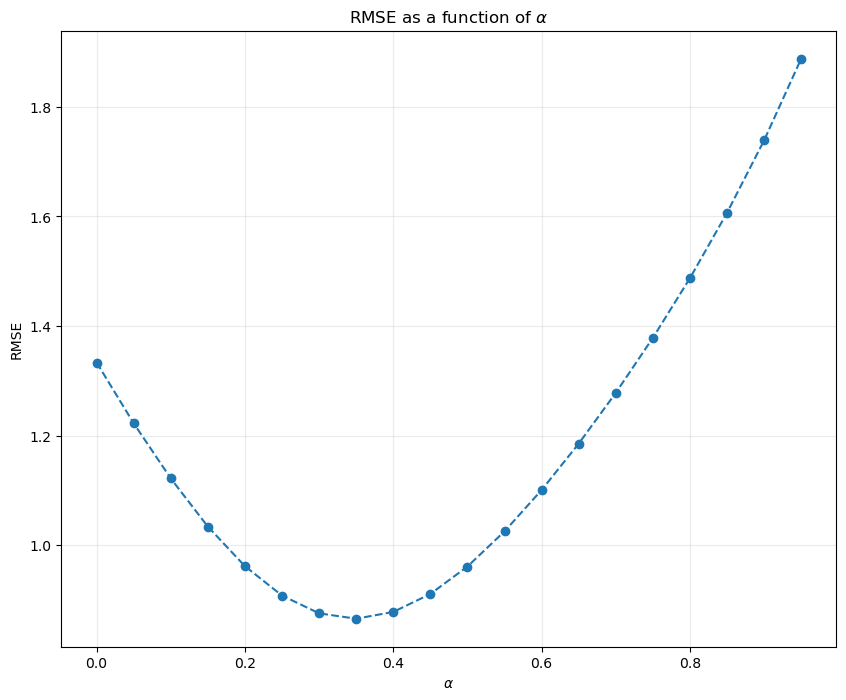

In [6]:
#Plotto la superficie di H
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, "o--")
plt.grid(alpha=0.25)
plt.xlabel("$\\alpha$")
plt.ylabel("RMSE")
plt.title("RMSE as a function of $\\alpha$")

plt.show()

In [11]:
#Optimization routine
#strarting point: [ 2.3     0.046   0.0825 -0.53    0.054 ]
params = [2.3, 0.046, 0.0825, -0.53, 0.054]

#NELDER-MEAD
from scipy.optimize import fmin

def callbackF(xi):
    global num_iter
    global arg
    print("i = " + str(num_iter))
    print("x_i = " + str(xi))
    print("f_i = " + str(mcf.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)

num_iter = 1
t = fmin(
    mcf.eValue,
    params,
    args = arg,
    xtol=1e-4,
    ftol=1e-4,
    maxiter=20,
    maxfun=100,
    callback=callbackF,
    disp=True,
    retall=False,
    full_output=True
)

print("optimal params:")
print(t[0])
print("f: " + str(t[1]))
       

i = 1
x_i = [ 2.369     0.04738   0.084975 -0.5459    0.0486  ]
f_i = 0.6687828051714751
i = 2
x_i = [ 2.4104    0.042228  0.08646  -0.55544   0.05076 ]
f_i = 0.5433962703792162
i = 3
x_i = [ 2.4104    0.042228  0.08646  -0.55544   0.05076 ]
f_i = 0.5433962703792162
i = 4
x_i = [ 2.4104    0.042228  0.08646  -0.55544   0.05076 ]
f_i = 0.5433962703792162
i = 5
x_i = [ 2.6462144   0.04318701  0.08419356 -0.57161984  0.04383936]
f_i = 0.3515829396426812
i = 6
x_i = [ 2.50829536  0.04299948  0.08980646 -0.5743945   0.04316198]
f_i = 0.3498782964476969
i = 7
x_i = [ 2.50829536  0.04299948  0.08980646 -0.5743945   0.04316198]
f_i = 0.3498782964476969
i = 8
x_i = [ 2.50829536  0.04299948  0.08980646 -0.5743945   0.04316198]
f_i = 0.3498782964476969
i = 9
x_i = [ 2.50829536  0.04299948  0.08980646 -0.5743945   0.04316198]
f_i = 0.3498782964476969
i = 10
x_i = [ 2.50829536  0.04299948  0.08980646 -0.5743945   0.04316198]
f_i = 0.3498782964476969
i = 11
x_i = [ 2.50829536  0.04299948  0.08980646

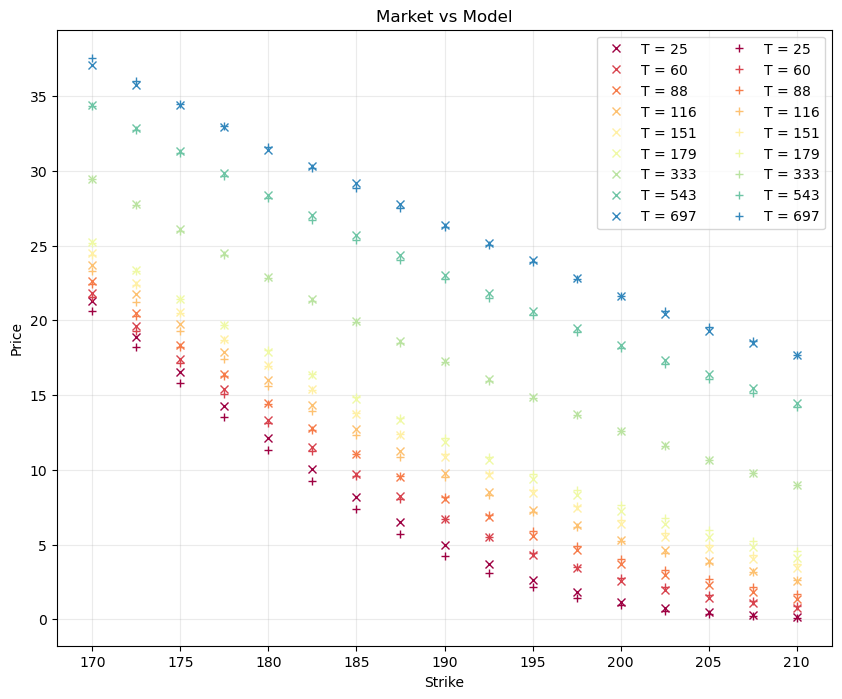

In [12]:
#Plotto Model vs Market
params2 = t[0]
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_years[i]
        K = strikes[j]
        [km, cT_km] = mcf.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices[i, j] = cT_km[0]

#plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
colors = [colormap(i) for i in np.linspace(0, 0.9, lenT)]
plt.gca().set_prop_cycle(color=colors)
for i in range(lenT):
    plt.plot(strikes, callPrices[i, :], "x")
    labels.append("T = " + str(maturities[i]))

for i in range(lenT):
    plt.plot(strikes, modelPrices[i, :], "+")
    labels.append("T = " + str(maturities[i]))

plt.legend(labels, loc="best", ncol=2)
plt.grid(alpha=0.25)
plt.xlabel("Strike")
plt.ylabel("Price")
plt.title("Market vs Model")
plt.show()
                                 